# Tensor trains

In [2]:
import numpy as np
import tt
import pylab as plt
import numpy.linalg as LA
from scipy.linalg import eigh
import pandas as pd
from tt.amen import amen_solve
from tt.cross import rect_cross
import time
from tqdm import tqdm

Здесь будет небольшая методичка по методологии и использованию тензорных сетей для решения PDE и взятия интегралов. Для решений будет использоваться библиотека [tt.py](https://github.com/oseledets/ttpy/blob/master/tt/core/tt.py). Также в конце будет пара примеров и список полезной литературы.

# Оглавление

## Тензорные сети (введение)
### 1.1 Тензоры: обозначения и операции с ними
    1.1.1 Операции с тензорами
    1.1.2 Тензорные разложения
    Пример 1.1.2 (Тензорные разложения)
### 1.2 Тензорный поезд
    Пример 1.2
### 1.3 Matrix product operator
### 1.4 Операции над тензорными поездами
    Пример 1.4
### 1.5 Алгоритм DMRG
    Пример 1.5
### 1.6 Алгоритм решения систем AMEn
### 1.7 Алгоритм Крестовой аппроксимации
### 1.8 Квантизованные тензорные аппроксимации (QTT)

## Пример (решение уравнения Пуассона)

## Пример (расчет интеграла через аппроксимацию)

## Тензорные сети

### 1.1 Тензоры: обозначения и операции с ними
Практически любой набор данных может быть представлен в виде массива чисел. Картинка - это массив значений интенсивностей каждого из 3-ех цветов в каждом пикселе, функции обычно представляются в виде массива ее дискретизованных значений, а текст - это массив закодированных символов. Многомерный массив чисел принято называть тензором. О тензорах и пойдет речь в данной секции.

Важной характеристикой любого тензора явлеяется его порядок - количество индексов тензора или его размерность. Например:
- Вектор - это тензор первого порядка.
- Матрица - это тензор 2-го порядка.
Тензор удобно схематически изображать в виду "кружочка с ножками", при этом число ножек соответствует порядку тензора. Порядок индексов обычно идет против часовой стрелке, начиная с 9-ти часов. Ниже представлены некоторые примеры:

![Fig 1](https://static.wixstatic.com/media/d91e93_6a91aeea94304044a62cc32d064aaf61~mv2.png/v1/fill/w_528,h_272,al_c,q_95,enc_auto/d91e93_6a91aeea94304044a62cc32d064aaf61~mv2.png)

### 1.1.1 Операции с тензорами
В ходе работы с тензорами часто приходится выполнять манипуляции с ними. Давайте рассмотрим наиболее часто используемые:
1. Операция транспонирования - меняет порядок индексов в тензоре.
Схематически это можно представить:
![Transpose](https://static.wixstatic.com/media/d91e93_6afe662a2ff44b3c8df018f0ac787b09~mv2.png/v1/fill/w_760,h_294,al_c,q_95,enc_auto/D18.png)


In [3]:
A = np.random.rand(4,4,4,4)
Atilda = A.transpose(3,0,1,2)

2. Операция "reshape" - группирует или разгруппировывает индексы тензора:
![Reshape](https://static.wixstatic.com/media/d91e93_6afe662a2ff44b3c8df018f0ac787b09~mv2.png/v1/fill/w_760,h_294,al_c,q_95,enc_auto/D18.png)


In [4]:
B = np.random.rand(4,4,4)
Btilda = B.reshape(4,4**2)

3. Свертка тензоров - производит суммированиние произведения тензоров по заданным индексам. При этом схематически этому соотвествует просто соедиение соответсвующих "ножек" тензоров. Например:
• Перемножение матриц
![](https://static.wixstatic.com/media/d91e93_4a2852f173884f0c96aa869aa6524ee7~mv2.png/v1/fill/w_763,h_260,al_c,q_95,enc_auto/d91e93_4a2852f173884f0c96aa869aa6524ee7~mv2.png)
• След матрицы
![](https://tensornetwork.org/diagrams/trace.png)
Тензорной сетью мы будем называть свертку нескольких тензоров:
![](https://tensornetwork.org/tensor_networks.png)
Важно понимать, что общая стоимость свертки тензорной сети сильно зависит от последовательности, в которой производятся перемножения тензоров:
![](https://static.wixstatic.com/media/d91e93_27f38171fdb04152a27551492a6c6b7d~mv2.png/v1/fill/w_600,h_66,al_c,q_95,enc_auto/d91e93_27f38171fdb04152a27551492a6c6b7d~mv2.png)
И в общем случае, найти оптимальную последовательность свертки - NP-сложная задача, и существует много эвристических подходов по нахождению
субоптимальной последовательности.

### 1.1.2 Тензорные разложения
Важным матричным разложением, часто встречающемся при работе с тензорными сетями является Singular Value decomposition (SVD).

Определение 1.1.1. (SVD) Любую матрицу $n \times m(n \geq m)$ можно представить в виде:
$$
A_{n \times m}=U_{n \times m} S_{m \times m} V_{m \times m}^{\dagger}
$$
где $U$ - изометрия, т.е. $U^{\dagger} U=I, S$ - диагональная матрица с неотрицательными вещественными элементами на ней, $V$ - унитарная матрица, т.е. $V^{\dagger} V=V V^{\dagger}=I$

Данное разложение имеет сложность $O\left(m^2 n\right)$. А схематически изображается:

![](https://static.wixstatic.com/media/d91e93_41252d23123a4b2c9304b350b4b641fc~mv2.png/v1/fill/w_754,h_206,al_c,q_95,enc_auto/d91e93_41252d23123a4b2c9304b350b4b641fc~mv2.png)

In [9]:
d1 = 10; d2 = 6
A = np.random.rand(d1,d2)
[U,S,Vh] = LA.svd(A,full_matrices=False)
# check result
Af = U @ np.diag(S) @ Vh
dA = LA.norm(Af-A)
dA

1.8487801716568117e-14

Часто для оценки точности алгоритма требуется считать норму тензора. Для этого, в рамках всей работы, мы будем использовать норму Фробениуса. Например, для матрица она определяется как
#### Определение 1.1.2. (Норма Фробениуса для матрицы)
$$
\|A\|=\sqrt{\sum_{i j}\left|A_{i j}\right|^2}=\sqrt{\operatorname{tr}\left(A^{\dagger} A\right)}
$$
Если применить разложение SVD и подставить в формулу для нормы, получим:
$$
\|A\|=\sqrt{\operatorname{tr}\left(S^2\right)}
$$
Также это можно показать схематически:
![](https://static.wixstatic.com/media/d91e93_4fb8eb3d3eed467a9be07c0f9bda030c~mv2.png/v1/fill/w_691,h_130,al_c,q_95,enc_auto/d91e93_4fb8eb3d3eed467a9be07c0f9bda030c~mv2.png)

In [12]:
d = 10; A = np.random.rand(10,10,10,10,10)
# frobenus norm
frobA1 = np.sqrt(sum(abs(A.flatten())**2))
# equivalent frobenus norm
frobA2 = LA.norm(A)
print(frobA1, frobA2)

182.41077803047193 182.4107780304705


Часто, при работе с тензорными сетями, возникает задача аппроксимации заданной матрицы метрицей меньшего ранга. Это задача имеет точное решение через SVD:

#### Теорема 1.1.2. 
Пусть $A_{n \times m}=U_{n \times m} S_{m \times m} V_{m \times m}^{\dagger}$, где элементы матрицы $S$ расположены по невозрастанию, тодда наилучшим приближением по норме Фробениуса матрицей ранга $r$ будет:
$$
A_r=\tilde{U}_{n \times r} \tilde{S}_{r \times r} \tilde{V}_{r \times m}^{\dagger}
$$
где $\tilde{U}, \tilde{S}, \tilde{V}$ получаются из $U, S, V$ обрезанием соответствующих строк u столбцов.

При этом ошибка будет порядка первого обрезанного сингулярного значения $S[r+1, r+1]$.

#### Замечение.
SVD-разложение довольно долгое, т.к. работает за $O\left(n^3\right)$ для кадратных мариц. Поэтому хочется использовать какой-нибудь другой квази-оптимального, но значительно более быстрый метод. Для этого может подойти алгоритм крестовой интерполяции:

Пусть дана матрицу $A_{n \times m}$ ранга $R$, тогда для любых наборов из $\mathrm{R}$ индексов $\mathcal{I}, \mathcal{J}$ таких, что $A[\mathcal{I}, \mathcal{J}]$ - обратима верно, что
$$
A=A[:, \mathcal{J}] \cdot A[\mathcal{I}, \mathcal{J}]^{-1} \cdot A[\mathcal{I},:]=A_R
$$
В случае, если необходима аппроксимация рангом $r<R$, то для ее нахождения достаточно выбрать $\mathrm{r}$ индексов $\mathcal{I}, \mathcal{J}$ с аналогичным требованием. При этом
$$
\left\|A-A_r\right\| \rightarrow \min \text { при } \operatorname{vol}(A[\mathcal{I}, \mathcal{J}]) \rightarrow \max
$$
где $\operatorname{vol}(\cdot)$ - это объем матрицы (модуль детерминанта). Таким образом, задача аппроксимации сводится к задаче отыскания подматрицы максимального объема. Существует субоптимальный алгоритм по нахождению такой подматрицы, работающий за $O\left(n r^2\right)$, который будет подробно рассмотрен в секции 1.8.

### Пример 1.1.2 "Тензорные разложения": 

![](https://static.wixstatic.com/media/d91e93_a8364e080c81427bbd5c43e9cd51738a~mv2.png/v1/fill/w_600,h_128,al_c,q_95,enc_auto/D21.png)
Тензор A — это тензор порядка 4, который мы определяем поэлементно, как указано выше.

(a) Предположим, что индексы i, j имеют размерность d1, а индексы k, l имеют размерность d2 (при этом d2 < d1). Как масштабируется стоимость переноса SVD через указанный раздел с d1 и d2?

(b) Сгенерируйте тензор A для d1 = 10 и d2 = 8. Какова норма ‖A‖? После вычисления нормы построим нормированный тензор: A' = A / ‖A‖.

(c) Проведите SVD A' через указанную перегородку. Убедитесь, что квадратный корень из суммы квадратов сингулярных значений равен 1. Почему это так?

(d) Каков эффективный ранг r(∆) группы A' при ∆ = 1e-4?

(e) Вычислите ошибку усечения ε приближения с ограниченным рангом r(Δ=1e-4) косвенно, используя сингулярные значения, как показано на рис. 2.4(c).

(f) Построить оптимальное приближение ограниченного ранга к A' с помощью усеченного SVD. Вычислите ошибку усечения ε этого приближения и убедитесь, что ваш ответ согласуется с пунктом (e). Построить график ошибки аппроксимации от ранга.

Frobenius norm of matrix is 554.2562584220408
Square root of the sum of the singular values squared is 1.0000000000000002
Effective rank (tol = 1e-4) is 3
Truncation error is 1.0484615133225791e-05
New error is 1.0484615133211117e-05


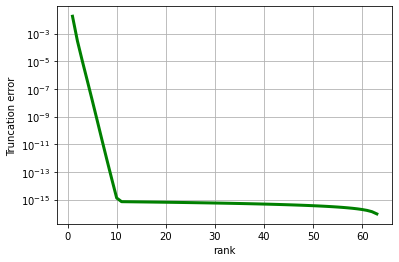

In [14]:
# O(d1^2*d2^4)

d1 = 10
d2 = 8
A = np.zeros((d1,d1,d2,d2))
for i in range(d1):
    for j in range(d1):
        for k in range(d2):
            for l in range(d2):
                A[i, j, k, l] = np.sqrt((i + 1) + 2*(j + 1) + 3*(k + 1) + 4*(l + 1))
            
norm = np.sqrt(np.sum(np.abs(A.flatten())**2))
print("Frobenius norm of matrix is", norm)
A_ = A/norm

U, S, V = np.linalg.svd(A_.reshape(d1**2,d2**2))
norm_ = np.sqrt(np.sum(S**2))
print("Square root of the sum of the singular values squared is", norm_)

tol = 1e-4
eff_rank = np.sum(S > tol)
print("Effective rank (tol = 1e-4) is", eff_rank)

error = np.sqrt(np.sum((S[eff_rank : ])**2))
print("Truncation error is", error)

new_A = (U[:, : eff_rank] @ np.diag(S[: eff_rank]) @ V[: eff_rank, :]).reshape(d1,d1,d2,d2)
new_error = np.sqrt(np.sum(np.abs((A_ - new_A).flatten())**2))

print("New error is", new_error)

max_rank = len(S)

errors = []

for rank in range(1, max_rank):
    errors.append(np.sqrt(np.sum((S[rank : ])**2)))
    
plt.plot(np.arange(1, max_rank), errors, lw=3, c='g')
plt.xlabel('rank')
plt.ylabel('Truncation error')
plt.yscale('log')
plt.grid()
plt.show()

### 1.2 Тензорный поезд
Существует много видов тензорных разложений (тензорных сетей): канонический формат, формат Таккера, Иерархическое разложение Таккера, MERA или даже обобщенные древовидные тензорные сети. Однако самым простым и часто-используемым является, так называемый, формат тензорного поезда. Изначально этот формат появился в физике в 90-ых годах под названием Matrix Product State (MPS) для решения многочастичных задач квантовой физики. Далее, в 2010 году, этот формат был обобщен в математике под именем Tensor Train (TT). В этой работе были систематизированы все операции над тензорынми поездами (сложение, поэлементное и скалярное произведения и др.).
Схематически, тензорный поезд представляется как:

![](https://tensornetwork.org/mps/mpstt_diagram.png)

В качестве альтернативы факторизация тензора MPS / TT может быть выражена в традиционных обозначениях как:

$$
T^{s_1 s_2 s_3 s_4 s_5 s_6}=\sum_{\{\alpha\}} A_{\alpha_1}^{s_1} A_{\alpha_1 \alpha_2}^{s_2} A_{\alpha_2 \alpha_3}^{s_3} A_{\alpha_3 \alpha_4}^{s_4} A_{\alpha_4 \alpha_5}^{s_5} A_{\alpha_5}^{s_6}
$$

Любой тензор порядка $d$ можно представить таким образом, делая последовательные SVD-разложения или крестовую аппроксимацию. Основной характеристикой тензорного поезда является его ранг $r$ - это максимальный размер связывающих "ножек". А связывающие тензора мы будем называть тт-ядрами.

![](https://tensornetwork.org/mps/bond_external_dim.png)

Можно сравнить количество элементов в полном тензоре и его представлении через тензорный поезд. В полном виде, очевидно, тензор имеет $n^d$ элементов, где $n$ - размерность открытого индекса, а $d$ - порядок тензора. При этом тензорный поезд содержит лишь $d n r^2$ элементов, то есть в случае малого ранга $r$ происходит экспонециальное сжатие.

Далее, для представления тензоров в формате тензорного поезда нам понадобится, так называемое, ранговое произведение:
#### Определение 1.2.1.

$$
\left[\begin{array}{cc}
A_1 & A_2 \\
A_3 & A_4
\end{array}\right] \bowtie\left[\begin{array}{cc}
B_1 & B_2 \\
B_3 & B_4
\end{array}\right]=\left[\begin{array}{ll}
A_1 \otimes B_1+A_2 \otimes B_3 & A_1 \otimes B_2+A_2 \otimes B_4 \\
A_3 \otimes B_1+A_4 \otimes B_3 & A_3 \otimes B_2+A_4 \otimes B_4
\end{array}\right]
$$

Где $A_i$ и $B_j$ - вектор-столбцы или матрицы. При этом ранговое произведение - ни что иное, как произведение двух тт-ядер. Стоит заметить, что размер соединяющих матриц и является рангом тензорного поезда. Например, нулевое состояние:

$$
|000\rangle=[|0\rangle] \bowtie[|0\rangle] \bowtie[|0\rangle]
$$

представимо в виде MPS (= TT) ранга 1. 

### Пример 1.2

Дан 4-ех мерный тензор A(i1, i2, i3, i4) = sin( i1 +i2+ i3+ i4). Возьмите размеры индексов [10, 15, 20]. Разложить в ТТ с точность 10^(-6). Найти ранг этого поезда.

In [15]:
def TT_decomp(A, r):
    TT = []
    n = A.shape[0]
    A_ = (A.copy()).reshape(n, -1)
    
    T, S, V = np.linalg.svd(A_)
    TT.append(T[:, :r])
    A_ = np.diag(S[:r])@V[:r, :]
    A_ = A_.reshape(n*r, -1)
    
    for i in range(2, len(A.shape)):

        T, S, V = np.linalg.svd(A_)
        TT.append(T[:, :r].reshape(r, n, r))
        A_ = np.diag(S[:r])@V[:r, :]
        A_ = A_.reshape(n*r, -1)
        
    TT.append(A_.reshape(r, n))
    return TT

n = 10
r = 2

A = np.zeros((n, n, n, n))
i, j, k, l = np.indices(A.shape)

A[i, j, k, l] = np.sin(i + j + k + l)

TT = TT_decomp(A, r)

print("Error for rank = 2 and n = 10 is", np.sqrt(np.sum(np.abs((A - np.einsum('ij,jkl,lmn,no->ikmo', TT[0], TT[1], TT[2], TT[3]) ).flatten())**2)))

r = 1
TT = TT_decomp(A, r)

print("Error for rank = 1 and n = 10 is", np.sqrt(np.sum(np.abs((A - np.einsum('ij,jkl,lmn,no->ikmo', TT[0], TT[1], TT[2], TT[3]) ).flatten())**2)))

n = 15
r = 2
A = np.zeros((n, n, n, n))
i, j, k, l = np.indices(A.shape)

A[i, j, k, l] = np.sin(i + j + k + l)
TT = TT_decomp(A, r)

print("Error for rank = 2 and n = 15 is", np.sqrt(np.sum(np.abs((A - np.einsum('ij,jkl,lmn,no->ikmo', TT[0], TT[1], TT[2], TT[3]) ).flatten())**2)))

r = 1
TT = TT_decomp(A, r)

print("Error for rank = 1 and n = 15 is", np.sqrt(np.sum(np.abs((A - np.einsum('ij,jkl,lmn,no->ikmo', TT[0], TT[1], TT[2], TT[3]) ).flatten())**2)))

n = 20
r = 2
A = np.zeros((n, n, n, n))
i, j, k, l = np.indices(A.shape)

A[i, j, k, l] = np.sin(i + j + k + l)
TT = TT_decomp(A, r)

print("Error for rank = 2 and n = 20 is", np.sqrt(np.sum(np.abs((A - np.einsum('ij,jkl,lmn,no->ikmo', TT[0], TT[1], TT[2], TT[3]) ).flatten())**2)))

r = 1
TT = TT_decomp(A, r)

print("Error for rank = 1 and n = 20 is", np.sqrt(np.sum(np.abs((A - np.einsum('ij,jkl,lmn,no->ikmo', TT[0], TT[1], TT[2], TT[3]) ).flatten())**2)))

Error for rank = 2 and n = 10 is 8.072221215484714e-14
Error for rank = 1 and n = 10 is 64.96543010687218
Error for rank = 2 and n = 15 is 1.3137930877114765e-13
Error for rank = 1 and n = 15 is 147.3748016477823
Error for rank = 2 and n = 20 is 2.2575216572613314e-13
Error for rank = 1 and n = 20 is 261.7946605684132


### 1.3 Matrix Product Operator

![](https://tensornetwork.org/mpo/mpo.png)

Кроме того, матрицы можно также представлять в формате тензорного поезда, мы их будем называть Matrix Product Operators (MPO). B этом случае в ранговом произведении $A_i$ и $B_j$ будут уже матрицы:

$$
\underbrace{\left[\begin{array}{cc}
A_1^{s i} & A_2^{s i} \\
A_3^{s i} & A_4^{s i}
\end{array}\right]}_l\} k \bowtie \underbrace{\left[\begin{array}{ll}
B_1^{p j} & B_2^{p j} \\
B_3^{p j} & B_4^{p j}
\end{array}\right]}_m\} l
$$

В традиционных обозначениях MPO представляет собой тензорную сеть вида:

$$
M_{s_1^{\prime} s_2^{\prime} s_3^{\prime} s_4^{\prime} s_5^{\prime} s_6^{\prime}}^{s_1 s_2 s_3 s_4 s_5 s_6}=\sum_{\{\alpha\}} A_{s_1^{\prime}}^{s_1 \alpha_1} A_{\alpha_1 s_2^{\prime}}^{s_2 \alpha_2} A_{\alpha_2 s_3^{\prime}}^{s_3 \alpha_3} A_{\alpha_3 s_4^{\prime}}^{s_4 \alpha_4} A_{\alpha_4 s_5^{\prime}}^{s_5 \alpha_5} A_{\alpha_5 s_6^{\prime}}^{s_6}
$$

- Рассмотрим локальный Гамильтониан Изинга для спиновой цепочки в перпендекулярном магнитном поле:

$$
H=-J \sum_{i=1}^{d-1} \sigma_i^z \sigma_{i+1}^z-h \sum_{i=1}^d \sigma_i^x
$$

Его можно представить как

$$
H=\left(\begin{array}{lll}
-h s^x & J s^z & I
\end{array}\right) \bowtie\left(\begin{array}{ccc}
I & 0 & 0 \\
s^z & 0 & 0 \\
-h s^x & J s^z & I
\end{array}\right) \bowtie \ldots \bowtie\left(\begin{array}{c}
I \\
s^2 \\
-h s^x
\end{array}\right)
$$

то есть в виде МPO ранга 3.
- Также можно рассмотреть оператор Лапласса:

$$
\begin{gathered}
\Delta=\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}+\frac{\partial^2}{\partial z^2}=\hat{A}_x \otimes \hat{I}_y \otimes \hat{I}_z+\hat{I}_x \otimes \hat{A}_y \otimes \hat{I}_z+\hat{I}_x \otimes \hat{I}_y \otimes \hat{A}_z= \\
=\left(\begin{array}{cc}
\hat{A}_x & I
\end{array}\right) \bowtie\left(\begin{array}{cc}
I & 0 \\
\hat{A}_y & I
\end{array}\right) \bowtie\left(\begin{array}{c}
I \\
\hat{A}_z
\end{array}\right)
\end{gathered}
$$

То есть он представляется в виде МРO ранга 2. Аналогично рассматривается случай многомерного Лапласа.

### 1.4 Операции над тензорными поездами
Пускай у нас есть два вектора $A, B$, представленных в виде MPS ранга $r_A$ и $r_B$, тогда:
- Скалярное произведение этих векторов записывается как свертка:

![](https://tensornetwork.org/mps/InnerMPSTT.png)

Сложность данной операции $O\left(d n r_A r_B \max \left(r_A, r_B\right)\right)$.

- Чтобы обратиться к элементу вектора $A$ с индексами $i_1, i_2, \ldots i_d$ нужно лишь скалярно умножить его на ранг-1 вектор $B$, соответствующего элемента:

$$
B=\left|i_1\right\rangle \otimes\left|i_2\right\rangle \otimes \ldots \otimes\left|i_d\right\rangle
$$

Сложность данной операции $O\left(d n r_A^2\right)$.

- Чтобы найти сумму векторов, нужно лишь объеднить тт-ядра:

$$
A+B=\left[\begin{array}{ll}
A^{(1)} & B^{(1)}
\end{array}\right] \bowtie\left[\begin{array}{cc}
A^{(2)} & 0 \\
0 & B^{(2)}
\end{array}\right] \bowtie \ldots \bowtie\left[\begin{array}{l}
A^{(d)} \\
B^{(d)}
\end{array}\right]
$$

ранг получившегося вектора равен $r_A+r_B$.
- Можно вытянуть вектор $A$ в диагональную матрицу и получить, тем самым, МРО того же ранга $r_A$ с помощью (с каждым ядром вектора сворачиваем вспомогательное ядро):

![](https://github.com/nalsur-veallam/Python/blob/main/comp_math/6sem/pictures/1.png?raw=true)

- Чтобы произвести поэлементное произведение двух векторов, можно вытянуть один из них в диагональную матрицу, а затем произвести матрично-векторное произведение. Оно будет выполняться за $O\left(d n^2 r_A^3 r_B^3\right)$, а получившийся тензор, в общем случае, будет иметь ранг $r_A \cdot r_B$.

![](https://github.com/nalsur-veallam/Python/blob/main/comp_math/6sem/pictures/2.png?raw=true)

- Мы видим, что алгебраические операции могут увеличивать ТТранги, при этом они могут получаться завышенными для данных тензоров и точностей. Поэтому важной операцией для тензорных поездов является сжатие рангов или округление ([описание алгоритма](https://tensornetwork.org/mps/#toc_6)). Для этого нужно произвести ортогонализацию и последовательные SVD разложения. Алгоритм имеет сложность $O\left(d n r_A^3\right)$, где $r_A$ - изначальный ранг тензора.

![](https://tensornetwork.org/mps/mpstt_compress.png)

### Пример 1.4
Случайно сгенерировать два тензорных поезда (его тт-ядра) . d = 50, n =2, r = 5. Найти их скалярное произведение. Найти 10-ый элемент одного из поездов.

In [17]:
d = 50
n = 2
r = 5
index = 6

TT1 = []

TT1.append(np.random.rand(n, r))
for i in range(2,d):
    TT1.append(np.random.rand(r, n, r))
    
TT1.append(np.random.rand(r, n))


TT2 = []

TT2.append(np.random.rand(n, r))
for i in range(2,d):
    TT2.append(np.random.rand(r, n, r))
    
TT2.append(np.random.rand(r, n))

scalar = np.einsum("ij,ik->jk", TT1[0], TT2[0])
for i in range(2,d):
    scalar = np.einsum("jk,kon->jon", scalar, TT2[i-1])
    scalar = np.einsum("jon,jop->pn", scalar, TT1[i-1])
    
scalar = np.einsum("jk,ki->ji", scalar, TT2[-1])
scalar = np.einsum("ji,ji", scalar, TT1[-1])

print("Scalar product is", scalar)

elem = str(bin(index - 1))[2:]
for i in range(d-len(elem)):
    elem = "0" + elem

ind0 = np.array([1.0,0.0])
ind1 = np.array([0.0,1.0])
IND = []
for char in elem:
    if char == "0":
        IND.append(ind0)
    else:
        IND.append(ind1)
        
TT = []
TT.append(np.einsum("i,ij->j",IND[0],TT1[0]))

for i in range(2, d):
    TT.append(np.einsum("i,jik->jk",IND[i-1], TT1[i-1]))

TT.append(np.einsum("i,ji->j",IND[-1],TT1[-1]))

T = TT[0]
for i in range(2, d):
    T = np.einsum("i,ij->j", T, TT[i-1])

print("The element of the first vector at index", index-1, "is", np.einsum("i,i", T, TT[-1]))

Scalar product is 4.0111237189991335e+53
The element of the first vector at index 5 is 3.6406622405064873e+18


### 1.5 Алгоритм DMRG
В секции 1.3 мы рассмотрели, как представить локальный Гамильтониан в виде МРО. Давайте теперь попробуем найти основное состояние Гамильтониана $H$, представленного в виде МРО. Именно эта задача и была впервые решена с помощью тензорных сетей и дала им дальнейшее распространение. А именно, основное состояние Гамильтониана $H$ определеяется, как:

$$
\left|\psi_{\text {oсн }}\right\rangle=\underset{\langle\psi \mid \psi\rangle=1}{\operatorname{argmin}}\langle\psi|H| \psi\rangle
$$

Давайте предположим, что $\left|\psi_{\text {осн }}\right\rangle$ эффективного представляется в виде MPS малого ранга $r$. Как мы увидим далее, эта гипотеза, действительно, выполняется. Поэтому будем искать $\left|\psi_{\text {осн }}\right\rangle$ только среди $|\psi\rangle$, представимых в виде MPS. Тогда энергию можно представить в виде тензорной свертки:

![](https://github.com/nalsur-veallam/Python/blob/main/comp_math/6sem/pictures/3.png?raw=true)

Теперь учтем ограничение на норму основного состояния, введя функцию Лагранжа:

$$
\begin{gathered}
L(|\psi\rangle, \lambda)=\langle\psi|H| \psi\rangle-\lambda(\langle\psi \mid \psi\rangle-1) \\
\left|\psi_{\mathrm{ocH}}\right\rangle, E_{\mathrm{ocH}}=\underset{|\psi\rangle, \lambda}{\operatorname{argmin}} L(|\psi\rangle, \lambda)
\end{gathered}
$$

Теперь, чтобы найти минимум этого функционала, нужно продифференцировать по $|\psi\rangle$, но тогда мы получим обычную задачу на поиск собственных значений:

$$
H|\psi\rangle=\lambda|\psi\rangle
$$

Для многочастичных $H$ это сделать очень трудно или невозможно, т.к. размер матрицы $H$ равен $2^d$. Поэтому нужно воспользовать тезорной структурой и продиффернцировать не по всему $|\psi\rangle$, а лишь по одному из его ядер. Например, производная по пятому ядру $\langle\psi|$, т.е. $\partial L / \partial C_5^*$, рaвнa:

![](https://github.com/nalsur-veallam/Python/blob/main/comp_math/6sem/pictures/4.png?raw=true)

Вводя матрицы 𝐴, 𝐵 и вектор v:

![](https://github.com/nalsur-veallam/Python/blob/main/comp_math/6sem/pictures/5.png?raw=true)

Получаем задачу на обобщенные собственные значения $𝐴v = \lambda𝐵v$. При этом размер матриц 𝐴 и 𝐵 равны лишь $2𝑟^2$, и эта задача решается гораздо проще, чем первоначальная. Остается лишь найти v, отвечающий минимальному $\lambda$ и заменить соответствующее ядро на него. Таким образом, проходя последовательно по всем ядрам в обе стороны несоклько раз, мы получим очень хорошее приближение основного состояния. Данный алгоритм ([статья по этому алгоритму](https://doi.org/10.1103/PhysRevLett.69.2863)) является основной для алгоритма решения ситем AMEn.

### Пример 1.5

Реализовать алгоритм DMRG для цепочки из 3-ех спинов с локальным Гамильтонианом в перпендикулярном магнитном поле (взять ранг 3-5). Посчитать основное состояние просто через собственные вектора и сравнить с ответом, полученным через DMRG (это нормально, что получается такая точность. Задача плоха для тензорок (они не каждую задачу решают)).

In [40]:
Y = 1
h = 1
r = 5

pauli_z = np.array([[1, 0],[0, -1]])
pauli_x = np.array([[0, 1],[1, 0]])

Id = np.array([[1, 0],[0, 1]])
null = np.array([[0,0],[0,0]])

psi = []
psi.append(np.random.rand(2, r))
psi.append(np.random.rand(r, 2, r))
psi.append(np.random.rand(r, 2))

H = []
H.append(np.array([h*pauli_x, Y*pauli_z, Id]))
H.append(np.array([[Id, null, null],
              [pauli_z, null, null],
              [h*pauli_x, Y*pauli_z, Id]]))
H.append(np.array([Id, pauli_z, h*pauli_x]))

vec = np.einsum('il,ljm,mk->ijk', psi[0], psi[1], psi[2])
norm = np.sqrt(np.einsum("ijk,ijk", vec, vec))**(1/3)

psi[0] = 1/norm*psi[0]
psi[1] = 1/norm*psi[1]
psi[2] = 1/norm*psi[2]

Ham = np.einsum('ijk,ilmn,lop->jmoknp', H[0], H[1], H[2]).reshape(8,8)

eigval, eigvec = np.linalg.eig(Ham)

for step in range(3):
    A = np.einsum('ijk,kl,sut,rspj,rml,opn,nm->ituo', psi[1], psi[2], H[0], H[1], H[2], psi[1], psi[2]).reshape((2*r,2*r))
    B = np.einsum('ijk,kl,njm,ml,op->iopn', psi[1], psi[2], psi[1], psi[2], Id).reshape((2*r,2*r))

    B = B + np.eye(2*r)

    eigvals, eigvecs = eigh(A, b = B, type=1)
    table = pd.DataFrame(columns=['val', 'vec'])
    table['val'] = eigvals
    table['vec'] = eigvecs
    table = table.sort_values(by=['val'], ascending=True)
    psi[0] = np.array(table['vec']).reshape((2, r))
    
    A = np.einsum('ij,lm,nio,npkr,pms,ou,ts->jklurt', psi[0], psi[2], H[0], H[1], H[2], psi[0], psi[2]).reshape((2*r**2,2*r**2))
    B = np.einsum('ij,lm,ik,nm,op->jolkpn', psi[0], psi[2], psi[0], psi[2], Id).reshape((2*r**2,2*r**2))

    B = B + 1e-5*np.eye(2*r**2)

    eigvals, eigvecs = eigh(A, b = B, type=1)
    table = pd.DataFrame(columns=['val', 'vec'])
    table['val'] = eigvals
    table['vec'] = eigvecs
    table = table.sort_values(by=['val'], ascending=True)
    psi[1] = np.array(table['vec']).reshape((r, 2, r))
    
    A = np.einsum('ijk,lk,sut,rspj,rml,opn,mn->ituo', psi[1], psi[0], H[0], H[1], H[2], psi[1], psi[0]).reshape((2*r,2*r))
    B = np.einsum('ijk,lk,njm,lm,op->iopn', psi[1], psi[0], psi[1], psi[0], Id).reshape((2*r,2*r))

    B = B + 1e5*np.eye(2*r)

    eigvals, eigvecs = eigh(A, b = B, type=1)
    table = pd.DataFrame(columns=['val', 'vec'])
    table['val'] = eigvals
    table['vec'] = eigvecs
    table = table.sort_values(by=['val'], ascending=True)
    psi[2] = np.array(table['vec']).reshape((r, 2))
    
    
err = (np.sqrt(np.sum(np.abs((eigvec).flatten())**2)) - np.sqrt(np.sum(np.abs((np.einsum('il,ljm,mk->ijk', psi[0], psi[1], psi[2])).flatten())**2)))/np.sqrt(np.sum(np.abs((eigvec).flatten())**2))

print(err)

0.8002444104906673


### 1.6 Алгоритм решения систем AMEn
Как мы увидим далее, численное решение диффернциальных уравнений часто сводится к решению системы линейных уравнений, представленной в тензорном формате:

$$
A x=b
$$

Где матрциа $A$ представлена в виде MPO. А вектор $b$ в виде MPS:

![](https://github.com/nalsur-veallam/Python/blob/main/comp_math/6sem/pictures/6.png?raw=true)

Тогда нашей задачей является найти решение $x$ в формате MPS. Для этого можно воспользоваться алгоритмом AMEn ([статья по этому методу](https://epubs.siam.org/doi/10.1137/140953289)), который является комбинацией обобщенного алгоритма DMRG и алгоритма наискорейшего спуска решения систем.

![](https://github.com/nalsur-veallam/Python/blob/main/comp_math/6sem/pictures/7.png?raw=true)

Если матрица $A$ - эрмитова и положительно определена, то решение системы эквивалентно минимизации следующего функционала:

$$
\begin{gathered}
A x=b \Leftrightarrow \underset{x}{\operatorname{argmin}} J(x) \\
J(x)=\frac{1}{2}(x, A x)-(x, b)
\end{gathered}
$$

Что на языке тензорных сетей записывается, как:

![](https://github.com/nalsur-veallam/Python/blob/main/comp_math/6sem/pictures/8.png?raw=true)

Теперь можно воспользоваться схожей техникой, как в алгоритме DMRG. А именно, дифференцируем поочередно по каждому из ядер и приравниваем производную 0.

![](https://github.com/nalsur-veallam/Python/blob/main/comp_math/6sem/pictures/9.png?raw=true)

Так мы получаем "локальную"систему

$$
\hat{A} \hat{x}=\hat{b}
$$

размера $n r^2$ вместо $n^d$. Остается ее решить и заменить соответствующее ядро в векторе $x$.

Недостатком лишь такого подхода является то, что требует изначальной фиксации ТТ-рангов решения $x$, т.к. они не меняются в процессе. Это плохо, т.к. редко когда мы можем точно угадать их: если мы недооцениваем ранги, приближенное решение будет далеко от точного; если мы переоцениваем их, сложность локальных задач будет сильно завышена. Kроме того, алгоритм DMRG часто обладает стогнацией в локальных минимумах функционала.

Для борьбы с этими проблемами был предложен Alternaning Minimal Energy (AMEN) алгоритм ([статья по этому методу](https://epubs.siam.org/doi/10.1137/140953289)). Его особенностью, по сравнению с обычным DMRG, является то, что на каждом шаге происходит добавление к тт-ядру части невязки. А именно, после обновления тт-ядра при помомщи DMRG мы находим невязку $z=b-A x$. Далее, грубо аппроксимируем невязку $z$ с помощью MPS малого ранга и добавляем к обновленному ядру $x$ элементы соответствующего ядра $z$.

То есть, например, если после шага DMRG вектор $x$ имеет $k$-ое ядро:

$$
x^{(k)}=\left[\begin{array}{ll}
a^{(k)} & b^{(k)} \\
c^{(k)} & d^{(k)}
\end{array}\right]
$$

размера $[2, n, 2]$. Где вектор $x$ :

$$
x=x^{(1)} \bowtie x^{(2)} \bowtie \ldots \bowtie x^{(d)}
$$

А невязка $z$ после округления имеет $k$-ое ядро:

$$
z^{(k)}=\left[\begin{array}{cc}
e^{(k)} & f^{(k)} \\
g^{(k)} & h^{(k)}
\end{array}\right]
$$

такого же рармера $[2, n, 2]$. То мы обновляем $k$-ое и $(k+1)$-ое ядра вектора $x$ следующим образом:

$$
\begin{gathered}
x^{(k)}=\left[\begin{array}{cccc}
a^{(k)} & b^{(k)} & e^{(k)} & f^{(k)} \\
c^{(k)} & d^{(k)} & g^{(k)} & h^{(k)}
\end{array}\right] \\
x^{(k+1)}=\left[\begin{array}{cc}
a^{(k+1)} & b^{(k+1)} \\
c^{(k+1)} & d^{(k+1)} \\
0 & 0 \\
0 & 0
\end{array}\right]
\end{gathered}
$$

То есть увеличиваем $r_k$ ранг вектора $x$ и напрвляем его к глобальному решению системы. Заметим, что при таком обновлении, сам вектор $x$ не меняется, однако локальные системы в DMRG изменятся.

### 1.7 Алгоритм Крестовой аппроксимации
Важным алгоритмом по приближению произвольного тензора в виде тензорного поезда является алгоритм крестовой аппроксимации ([статья по этому методу](https://doi.org/10.1016/j.laa.2009.07.024). Пускай нам дан тензор размера $n^d$, который, заранее известно, представим в формате тензорного поезда ранга $r$, и нашей задачей является представить его в этом формате. Кроме того, пусть $n^d$ очень большое число, что мы не можем хранить все эелемента этого тензора в памяти. Поэтому мы не можем применить стандартный алгоритм, основнный на последовтальеном SVD разложении, к этой задаче, так как не можем задать весь тензор целиком. На помощь нам может прийти алгоритм крестовой аппроксимации тензора. Данный алгоритм позволяет произвести аппроксиммацию тензора, обращаясь лишь к $O\left(d n r^2\right)$ его элементам, а работа всего алгоритма имеет скейлинг $O\left(d n r^3\right)$, что гораздо быстрее SVD со скейлингом $O\left(n^d\right)$, даже если бы могли его исопльзовать. Для упрощения дальнейших выкладок давайте рассмотрим работу этого алгоритма на тензоре 2 порядка - матрице.

В секции 1.4 было показано, что для приближения матрицы матрицей меньшего ранга $r$, возникает задача нахождеения подматрицы размера $r \times r$ максимального объема (модуля детерминанта). Однако, это сама по себе NP-сложная задача, поэтому ее решают приближенно. Практика показывает, что подобный подход является субоптимальным.

Давайте рассмотрим конкретный пример, того что происходит. Пускай нам дана матрица $3 \times 3$, и мы хотим найти подматрицу максимального объема размера $2 \times 2$. В примере $n=3, r=2$ :

![](https://github.com/nalsur-veallam/Python/blob/main/comp_math/6sem/pictures/10.png?raw=true)

1. Случайным образом выбираем $r$ столбцовых индексов. В примере были выбрана $j=0,1$.
2. Находим все $n r$ элементов в столбцах с выбранными индексами.
3. В полученной матрице размера $n \times r$ находится подматрица максимального объема при помощи алгоритма maxvol. Это Занимает $O\left(n r^2\right)$ операций. Запоминаем индексы соответсвующих строк. В примере найдены строчные индексы $i=0,2$.
4. Находим все $n r$ элементов в строках с данными индексами.
5. В полученной матрице размера $r \times n$ находится подматрица максимального объема при помощи алгоритма maxvol. Это Занимает $O\left(n r^2\right)$ операций. Запоминаем индексы соответсвующих столбцов. В примере найдены столбцовые индексы $j=0,2$.
6. Это было сделана лишь одна итерация алгоритма. Если ее оказывается недостаточно (что чаще всего), то нужно повторить шаги (25) еще несоклько раз. В нашем примере одной итерации оказалось достаточно и мы нашли подматрицу максимального объема.

В ходе работы вышеизложенного алгоритма возникает Задача поиска в матрице $n \times r$ подматрицы $r \times r$ максимального объема. В такой формулировке эта задача оказывается еще сложнее SVD разложения, поэтому вместо подматрицы максимального объема ищут так называемую доминирующую матрицу - подматрицу, объем которой нельзя увеличить заменой 1 строки. Для этого используют алгоритм maxvol ([статья по этому методу](https://doi.org/10.1090/conm%2F280%2F4620).

В этом игрушечном примере, вместо определения всех 9 элементов матрицы $A$ нам потребовалось лишь 8 (не определенные элементы обозначены полупрозрачным цветовм). На практике, когда $n$ велико, эффект становится намного больше. Кроме того, алгоритм работает за $O\left(n r^2\right)$, вместо $O\left(n^3\right)$ для SVD. Также данный алгоритм обобщается на тензоры произвольного порядка.

Стоит отметить, что данный алгоритм также может быть использован для оптимизационных задач. Так как подматрицы максимального объема часто содержат и наибольшие по модулю элементы всего тензора.

### 1.8 Квантизованные тензорные аппроксимации (QTT)
Важным частным случаем тензорного поезда является квантизированный тензорный поезд. Например, при рассмотрении дифференциальных уравнений мы обычно имеем дело с пространствами не выше 3-ей степени. Поэтому представление матриц и решений в тензорном формате только по физическим размерностям имеет всего лишь 3 тт-ядра и обладает не слишком большим сжатием: $3 n R^2$ вместо $n^3$. Где $n$ - количество точек дискретизации по каждой из координат.

![](https://github.com/nalsur-veallam/Python/blob/main/comp_math/6sem/pictures/11.png?raw=true)

Поэтому хочется ввести исскуственные размерности и разложить каждую из пространственных координат в тензорный поезд и получить логарифмическое сжатие: $O\left(\log (n) r^2\right)$. Такое представление называется квантизованным тензорным поездом (QTT). Для более простого анализа давайте дальше рассмотрим лишь одномерное пространство. И попробуем разложить конкретные функции и матрицы в такой формат.

Оказывается что большая часть аналитических функций эффективно представима в QTT-формате. Например:
- Полином степени $p$ раскладывается в QТТ формат ранга $p+1$. Так, рассмотрим полином $f(x)=x$ на интервале $[0,7]$ в 8 равноудаленных точках:

$$
\left(\begin{array}{l}
0 \\
1 \\
2 \\
\vdots \\
6 \\
7
\end{array}\right)=\left[2^0\left(\begin{array}{l}
0 \\
1
\end{array}\right)\left(\begin{array}{l}
1 \\
1
\end{array}\right)\right] \bowtie\left[\begin{array}{c}
\left(\begin{array}{l}
1 \\
1
\end{array}\right) \\
2^1\left(\begin{array}{l}
0 \\
1
\end{array}\right)\left(\begin{array}{l}
0 \\
0 \\
1 \\
1
\end{array}\right)
\end{array}\right] \bowtie\left[\begin{array}{c}
\left(\begin{array}{l}
1 \\
1
\end{array}\right) \\
2^2\left(\begin{array}{l}
0 \\
1
\end{array}\right)
\end{array}\right]
$$

- Синус в QTT формате имеет ранг 2.
- Дельта функция имеет ранг 1, т.к. это просто $|0 \ldots 010 \ldots 0\rangle$.
- Функция Хэвисайда $\theta\left(x-x_0\right)$ имеет ранг 1 или 2 в зависимости от положения точки $x_0$. Если она стоит на четном месте в векторе, то:

$$
\theta=\left(\begin{array}{l}
0 \\
1
\end{array}\right) \otimes\left(\begin{array}{l}
0 \\
1
\end{array}\right) \otimes \ldots \otimes\left(\begin{array}{l}
0 \\
1
\end{array}\right) \otimes\left(\begin{array}{l}
1 \\
1
\end{array}\right) \otimes\left(\begin{array}{l}
1 \\
1
\end{array}\right) \otimes \ldots \otimes\left(\begin{array}{l}
1 \\
1
\end{array}\right)
$$

Факт, что разрывные дельта-функция и функция Хэвисайда приближаются в QTТ малого ранга, кажется очень интересным, так как на первый вгляд кажется, что функция должна обладать глаткостью для хорошего приближения.

Кроме того, важный класс Теплицевых матриц эффективно представляются в QTT формате ранга 3:

$$
\underbrace{\left(\begin{array}{ccccc}
\alpha & \beta & & & \\
\gamma & \alpha & \ddots & & \\
& \ddots & \ddots & \ddots & \\
& & \ddots & \alpha & \beta \\
& & & \gamma & \alpha
\end{array}\right)}_{2^4}=
$$

$$
\left[\begin{array}{lll}
I & J^T & J
\end{array}\right] \bowtie\left[\begin{array}{ccc}
I & J^T & J \\
& J & \\
& & J^T
\end{array}\right]^{\infty(d-2)} \bowtie\left[\begin{array}{c}
\alpha I+\beta J+\gamma J^T \\
\gamma J \\
\beta J^T
\end{array}\right]
$$

где:

$$
I=\left(\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right), \quad J=\left(\begin{array}{ll}
0 & 1 \\
0 & 0
\end{array}\right)
$$

Оказывается, если расписать операторы первой и второй производной в матричном виде после их дискретизации на равномерной сетке при помощи метода конечных разностей, они как раз окажутся Теплицевыми:

$$
\frac{\partial}{\partial x}=\left(\begin{array}{ccccc}
0 & 1 & & & \\
-1 & 0 & 1 & & \\
& \ddots & \ddots & \ddots & \\
& & -1 & 0 & 1 \\
& & & -1 & 0
\end{array}\right) \quad \frac{\partial^2}{\partial x^2}=\left(\begin{array}{ccccc}
-2 & 1 & & & \\
1 & -2 & 1 & & \\
& \ddots & \ddots & \ddots & \\
& & 1 & -2 & 1 \\
& & & 1 & -2
\end{array}\right)
$$

Именно поэтому решения большого класса дифференциальных уравнений с помощью тензорных сетей имеет логарифмическую сложность.

## Пример (решение уравнения Пуассона)

Задача выглядит следующим образом:

$$
-u^{\prime \prime}(x)=1 \text { в } \Omega=[0,1], u(0)=u(1)=0
$$

После стандартной конечно-разностной дискретизации уравнения в равноудаленньх узлах интервала мы получаем линейную систему:

$$
A x=b
$$

где

$$
A=\frac{1}{\Delta x^2} \underbrace{\left(\begin{array}{ccccc}
2 & -1 & & & \\
-1 & 2 & -1 & & \\
& \ddots & \ddots & \ddots & \\
& -1 & 2 & -1 \\
& & -1 & 2
\end{array}\right)}_N ; b=\left(\begin{array}{c}
1 \\
1 \\
\vdots \\
1 \\
1
\end{array}\right)
$$

Где $\Delta x=1 / N$ - шаг дискретизации интервала, а $N$ - размер матрицы, т.е. количество точек дискретизации. Стоит отметить, что матрица $A$ является эрмитовой и положительно определенной, с числом обусловленности $\kappa \sim N^2$. Также далее мы будем предполагать, что размер матрицы является степенью двойки, т.е. $N=2^n$. Эту системы мы решим 2-мя методами: алгоритмом AMEn на тензорных сетях и классическим алгоритмом.

#### Решение с помощью тензорных сетей

Заметим, что матрица $A$ является Теплицевой, поэтому, как было показано секции (1.9), ее можно представить в QТТ-формате ранга 3:
Вектор $b$ также представим в виде MPS ранга 1:

$$
b=\left(\begin{array}{l}
1 \\
1
\end{array}\right) \otimes\left(\begin{array}{l}
1 \\
1
\end{array}\right) \otimes \ldots \otimes\left(\begin{array}{l}
1 \\
1
\end{array}\right)
$$

Так как $A$ и $b$ представими в тензорном формате, систему можно решить с помощью алгоритма AMEn (секция 1.6).

Сначала классическое решение:

In [16]:
def poisson_classic(gridsize):
    A = np.zeros(shape=(gridsize,gridsize),dtype='d')
    b = np.ones(shape=(gridsize),dtype='d')
    
    dx = 1.0 / (gridsize - 1)
    
    # discretized differential operator
    for i in range(1,gridsize-1):
        A[i,i-1] = A[i,i+1] = 1/dx**2
        A[i,i] = -2/dx**2
    
    # boundary conditions
    for i in range(0,gridsize):
        A[0,0] = A[-1,-1] = 1
    
    # set the boundary values on the right side
    b[0] = b[-1] = 0
    
    time0 = time.time()
    y = np.linalg.tensorsolve(A,b)
    time1 = time.time()
    
    return y, time1-time0

In [17]:
def poisson_tt(d):
    A = tt.qlaplace_dd([d]) #создание матрицы в MPO-формате
    b = tt.ones(2, d) #создание правой части в TT-формате
    
    time0 = time.time()
    y = amen_solve(A,b,b,1e-6, verb=False) #A, b, initial prediction, accuracy
    time1 = time.time()

    return y.full().reshape(-1, order='F'), time1-time0

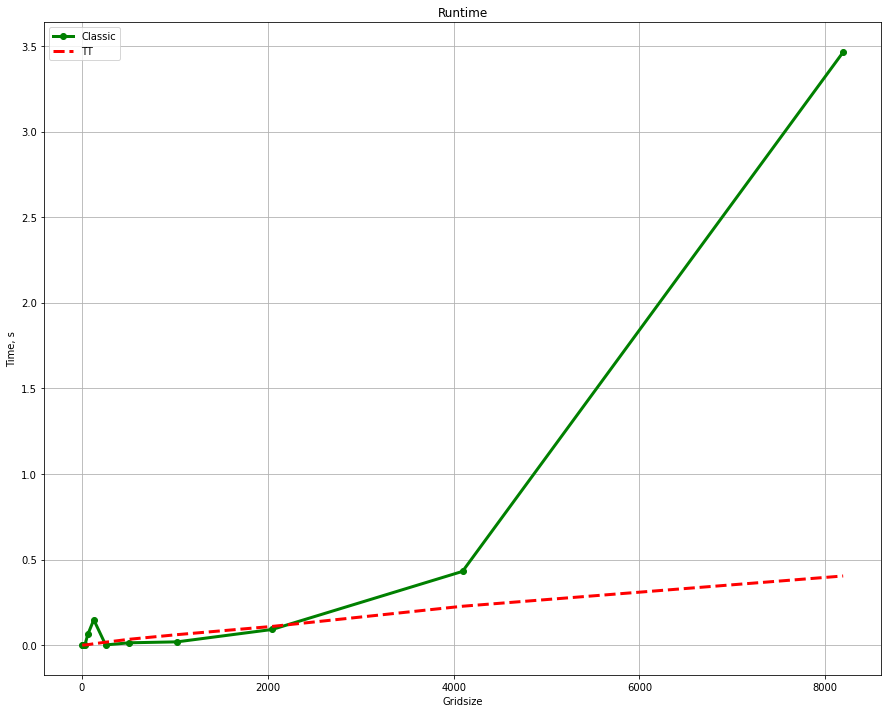

In [20]:
ds = np.arange(2, 14)
dy = []
times_classic = []
times_tt = []

for d in ds:
    
    y_classic, time_classic = poisson_classic(2**d)
    
    y_tt, time_tt = poisson_tt(d)
    
    dy.append(LA.norm(y_classic-y_tt)/LA.norm(y_classic))
    times_classic.append(time_classic)
    times_tt.append(time_tt)
    
plt.figure(figsize=(15, 12))
plt.plot(2**ds, times_classic, '-o', c='g', lw=3, label="Classic")
plt.plot(2**ds, times_tt, '--', c='r', lw=3, label="TT")
plt.grid()
plt.legend()
plt.xlabel("Gridsize")
plt.ylabel("Time, s")
plt.title("Runtime")
plt.show()

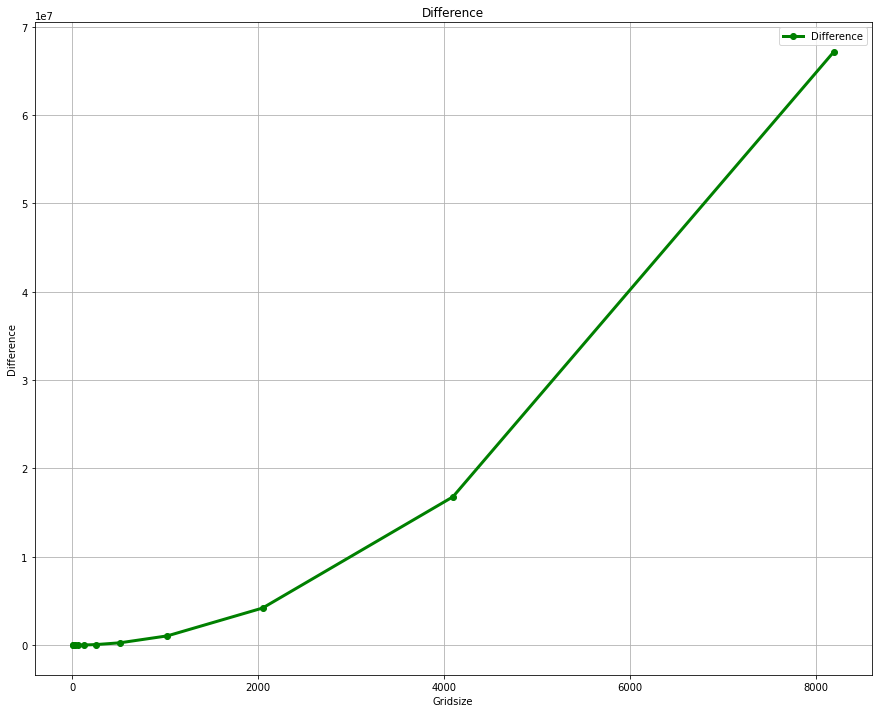

In [24]:
plt.figure(figsize=(15, 12))
plt.plot(2**ds, dy, '-o', c='g', lw=3, label="Difference")
plt.grid()
plt.legend()
plt.xlabel("Gridsize")
plt.ylabel("Difference")
plt.title("Difference")
plt.show()

## Пример (подсчет интеграла через аппроксимацию)

Рассчитать интеграл, представленный ниже и проанализировать точность подсчета в зависимости от n, d, tol, a. Посмотреть на ранги Гаусса в зависимости от этих же параметров. 

$$
I = \frac{1}{(2\pi)^{d/2}\sqrt{det(C)}}\int\limits_{\mathbb{R}^d}e^{-\frac{1}{2}x^TC^{-1}x}\, dx
$$

с матрицей ковариации:

$$
C =\left(\begin{array}{ccccc}
1 & 1 & 1 & \ddots & 1 \\
1 & 2 & 2 & \ddots & 2 \\
\ddots & \ddots & \ddots & \ddots & \ddots\\
1 & 2 & 3 & \ddots & d-1 \\
1 & 2 & \ddots & d-1 & d
\end{array}\right) 
$$

#### Решение тензорными сетями

Для начала, ограничим область интегрирования кубом $[-a,\,a]^d$. Идея интегрирования состоит в том, что мы эффективно "приближаем" подынтегральную функцию при помощи тензоных сетей на всей области интегрирования (то есть представляем ее в виде TT), а потом сворачиваем полученный тензор с единичным (то есть находим их скалярное произведение).

In [3]:
def genC(d):
    C = np.empty(shape=(d,d))
    for i in range(d):
        for j in range(d):
            if j >= i:
                C[i, j] = i+1
            else:
                C[i, j] = j+1
                
    return C
    
def con(d, C):
    return (2*np.pi)**(d/2)*np.sqrt(np.linalg.det(C))

def integrate(ind, h, C, a):
    coords = ind*h - a
    ans = coords @ C @ coords.T
    return np.exp(-1/2*np.diag(ans))
    
def solver(d, a, n, tol):
    C = genC(d)
    Cinv = np.linalg.inv(C)
    cons = con(d, C)
    
    h = 2*a / (n - 1)
    ones = tt.ones(n,d)
    
    func = rect_cross.cross(lambda arg: integrate(arg, h, Cinv, a),
                            tt.rand(n, d), nswp=7, eps=tol, kickrank=2, rf=1, verbose=False)
    integral = h**d/cons * tt.dot(ones, func)
    print(integral)

d = 2
tol = 1e-5
a = 10
n = 51

solver(d, a, n, tol)

As = [1, 2, 5, 10, 15]
ns = [5, 11, 21, 31]
tols = [1e-3, 1e-5, 1e-7]
ds = [1, 2, 3]

table = pd.DataFrame(columns=['d', 'a', 'n', 'tol', 'integral', 'loss', 'time', 'rank'])

for d in ds:
    C = genC(d)
    Cinv = np.linalg.inv(C)
    cons = con(d, C)
    
    for a in tqdm(As):
        for n in ns:
            h = 2*a / (n - 1)
            ones = tt.ones(n,d)
            for tol in tols:
                t_start= time.time()
                func = rect_cross.cross(lambda arg: integrate(arg, h, Cinv, a),
                            tt.rand(n, d), nswp=7, eps=tol, kickrank=2, rf=1, verbose=False)
                integral = h**d/cons * tt.dot(ones, func)
                loss = np.abs(1 - integral)
                t1 = time.time()
                new_row = pd.Series({'d': d, 'a' : a, 'n' : n, 'tol': tol, 'integral' : integral, 'loss': loss, 'time': t1-t_start, 'rank': np.max(func.r)})
                table = pd.concat([table, new_row.to_frame().T], ignore_index=True)
                
table = table.sort_values(by=['loss'], ascending=True, ignore_index=True)

0.9999999992499835


100%|█████████████████████████████████████████████| 5/5 [05:22<00:00, 64.45s/it]


In [4]:
table

,d,a,n,tol,integral,loss,time,rank
0,1.0,10.0,31.0,0.001,1.0,0.0,0.001657,1.0
1,1.0,10.0,31.0,0.0,1.0,0.0,0.00192,1.0
2,1.0,10.0,31.0,0.00001,1.0,0.0,0.001731,1.0
3,2.0,10.0,31.0,0.0,1.0,0.0,0.026816,26.0
4,2.0,10.0,31.0,0.00001,1.0,0.0,0.025909,26.0
...,...,...,...,...,...,...,...,...
175,2.0,15.0,5.0,0.0,8.952466,7.952466,0.004658,5.0
176,2.0,15.0,5.0,0.00001,8.952466,7.952466,0.004698,5.0
177,3.0,15.0,5.0,0.00001,26.786378,25.786378,0.008182,7.0
178,3.0,15.0,5.0,0.001,26.786378,25.786378,0.008569,7.0


## Полезные ссылки:

1) https://tensornetwork.org/
2) https://www.tensors.net/